In [1]:
import tqdm
import pickle, json
import numpy  as np
import pandas as pd
import torch
from itertools import chain
from nltk.corpus import wordnet as wn

from utils import tosn, get_imcount, get_wrdcount, get_split
from semantics import (GloVe, get_glove, 
                       base_glove, select_lemmas, 
                       ilsvrc_sem_df, ilsvrc_tree_df) 

from src.tree import get_tree, select_subset, select_split
from src.zsl import *

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

In [2]:
wrdcounts    = "./data/materials/wiki_counts" #"./data/new_counts"
#glove_cache = "../../data/word_embeddings/glove_vec"
#glove_type  = "6B"

In [3]:
def rep(wnids, df):
    v_tr = get_visu(trnodes)
    s_tr = get_sem(trnodes, df)
    v_te, s_te, l_te = get_data(wnids, df)
    w = get_W(v_tr, s_tr, 100, 1)
    res = v_te.mm(w)
    res = res.topk(1)[1].squeeze().cpu().numpy()
    idx = l_te.squeeze().cpu().numpy()
    s = pd.Series(res, index=idx)
    res = s.groupby(s.index).apply(lambda x: np.unique(x, return_counts=True)[1].max()/len(x)).mean()
    return res

def get_trivial_dfsem(wnids):
    trnodes_idx = np.asarray([dico[x] for x in trnodes])
    idx = np.asarray([dico[x] for x in wnids])
    adjmat = dist[trnodes_idx][:,idx]
    adjmat = (adjmat == adjmat.min(0, keepdims=True)).astype(int)
    adjmat = adjmat/adjmat.sum(axis=0, keepdims=True)
    dfte = pd.DataFrame(adjmat.transpose(), index=wnids)
    dftr = pd.DataFrame(np.eye(len(trnodes)), index=list(trnodes))
    df_sem = pd.concat([dftr, dfte])
    return df_sem

In [4]:
glove = GloVe()#glove_cache, glove_type)
imcounts = get_imcount()
wrdcounts= get_wrdcount(wrdcounts)
synsets  = imcounts.index.tolist()
lem_cond = {"wn":"strict"}#, "we":True}
word_cond= {"min":500, "max":1000000, "voc":glove.isin}
synswords=select_lemmas(synsets, lem_cond, word_cond, wrdcounts)

te_selecta = lambda x:x["type"]in [2,3]

100%|██████████| 21845/21845 [00:50<00:00, 430.46it/s]

5492 correct lemmas. (35249 lemmas removed). 17039 synsets removed for lack of correct lemmas


In [5]:
df_tree = ilsvrc_tree_df(synswords, imcounts, 100, 10**10)
df_sem  = ilsvrc_sem_df(synswords, glove)
tree = get_tree(df_tree)
dist, dico = tree.pairwise_dist()
dist[range(dist.shape[0]),range(dist.shape[0])]=100

82115it [00:04, 18209.30it/s]
100%|██████████| 82115/82115 [00:01<00:00, 44641.30it/s]


82115 84427 [60270, 17060, 3786, 999]
6503 6736 [710, 1008, 3786, 999]
5565 5795 [283, 497, 3786, 999]


5565it [01:55, 48.32it/s]


In [11]:
import h5py
storefile   = "/media/tristan/Samsung_T5/resnet_50_feat"
with h5py.File(storefile, "r") as f:
    tenodes = list(f.keys())

In [19]:
trnodes = get_split("train")
#tenodes = np.asarray(list(set(tree.nodes)-set(trnodes)))
tenodes = list(filter(lambda x:tree.node[x]["type"]==2, tree.nodes))
len(tenodes), len(trnodes)

(3786, 999)

In [20]:
df1 = ilsvrc_sem_df(synswords, glove)
df_sem = get_trivial_dfsem(tenodes)

In [22]:
tenodes = np.asarray(list(tenodes))
tenodes_idx = np.asarray([dico[x] for x in tenodes])
trnodes_idx = np.asarray([dico[x] for x in trnodes])

dst_tr = dist[trnodes_idx][:,tenodes_idx]
dst_te = dist[tenodes_idx][:,tenodes_idx]

mintr  = dst_tr.min(0)
meantr = dst_tr.mean(0)
minte  = dst_te.min(0)
meante = dst_te.mean(0)

ratio = mintr
IDX = ratio.argsort()
wnids = tenodes[IDX]

cs   = 100
step = 10

x_mintr, x_minte, x_minr, x_meantr, x_meante, x_meanr = [],[],[],[],[],[]
y1,y2,y3,z,G = [],[],[],[],[]

for i in range(0, len(tenodes), step):
    te = wnids[i:i+cs]
    if len(te)==cs:
        df_sem = get_trivial_dfsem(te)
        
        res1 = test_eszsl_sample(trnodes, te, df_sem)
        res2 = test_eszsl_sample(trnodes, te, df1)
        res3 = test_adgpm_sample(trnodes, te)
        g = rep(te, df_sem)
        
        trmin = mintr[IDX][i:i+cs]
        temin = minte[IDX][i:i+cs]
        trmean = meantr[IDX][i:i+cs]
        temean = meante[IDX][i:i+cs]
        #idx = np.asarray([dico[x] for x in te])
        
        x_mintr.append(trmin.mean())
        x_minte.append(temin.mean())
        x_minr.append((trmin/temin).mean())
        x_meantr.append(trmean.mean())
        x_meante.append(temean.mean())
        x_meanr.append((trmean/temean).mean())
        y1.append(res1[0])
        y2.append(res2[0])
        y3.append(res3[0])
        z.append(np.where(df_sem.loc[te.tolist()].values.sum(0))[0].shape[0])
        G.append(g)

100it [00:27,  3.63it/s]
100it [00:00, 1291.85it/s]
100it [00:00, 1556.58it/s]
100it [00:00, 1570.26it/s]
100it [00:03, 31.04it/s]
100it [00:00, 1518.11it/s]
100it [00:00, 1459.75it/s]
100it [00:00, 1652.75it/s]
100it [00:02, 34.83it/s]
100it [00:00, 1578.49it/s]
100it [00:00, 1511.28it/s]
100it [00:00, 1575.75it/s]
100it [00:02, 44.44it/s]
100it [00:00, 1327.58it/s]
100it [00:00, 1330.44it/s]
100it [00:00, 1559.40it/s]
100it [00:03, 28.13it/s]
100it [00:00, 1546.86it/s]
100it [00:00, 1460.62it/s]
100it [00:00, 1590.21it/s]
100it [00:03, 30.79it/s]
100it [00:00, 1505.94it/s]
100it [00:00, 1579.41it/s]
100it [00:00, 1354.22it/s]
100it [00:02, 33.97it/s]
100it [00:00, 1488.56it/s]
100it [00:00, 1204.69it/s]
100it [00:00, 1582.08it/s]
100it [00:03, 31.31it/s]
100it [00:00, 1547.07it/s]
100it [00:00, 1167.80it/s]
100it [00:00, 1655.10it/s]
100it [00:02, 42.83it/s]
100it [00:00, 1414.39it/s]
100it [00:00, 1378.62it/s]
100it [00:00, 1541.60it/s]
100it [00:02, 49.07it/s]
100it [00:00, 1467.07

In [41]:
#plt.plot(x2, y)
#plt.plot(x_minr, y1)
#plt.plot(x_minr, y2)
#plt.plot(G)
#len(tenodes)#i

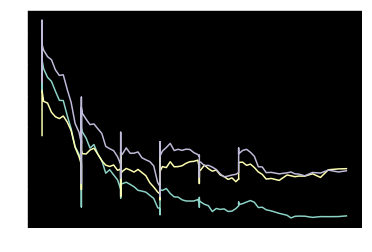

In [23]:
plt.plot(x_mintr, y1)
plt.plot(x_mintr, y2)
plt.plot(x_mintr, y3)

In [28]:
#x_minr[::3]
samp=3

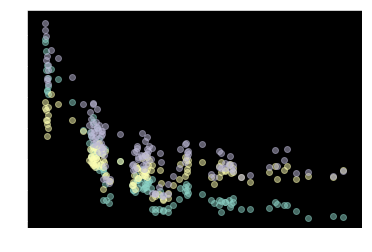

In [29]:
plt.scatter(x_minr[::samp], y1[::samp], alpha=0.5)
plt.scatter(x_minr[::samp], y2[::samp], alpha=0.5)
plt.scatter(x_minr[::samp], y3[::samp], alpha=0.5)

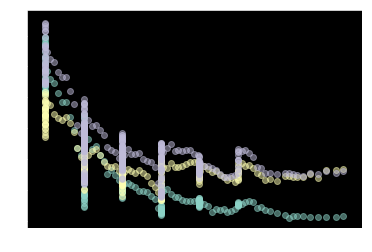

In [25]:
plt.scatter(x_mintr, y1, alpha=0.5)
plt.scatter(x_mintr, y2, alpha=0.5)
plt.scatter(x_mintr, y3, alpha=0.5)

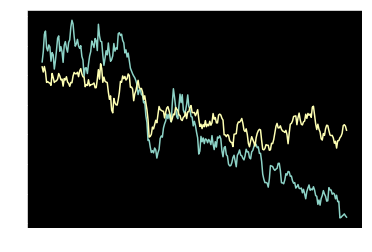

In [203]:
plt.plot(y1)
plt.plot(y2)
plt.plot(z, y1)

# Homonimy

# Image count

# Lemma frequency